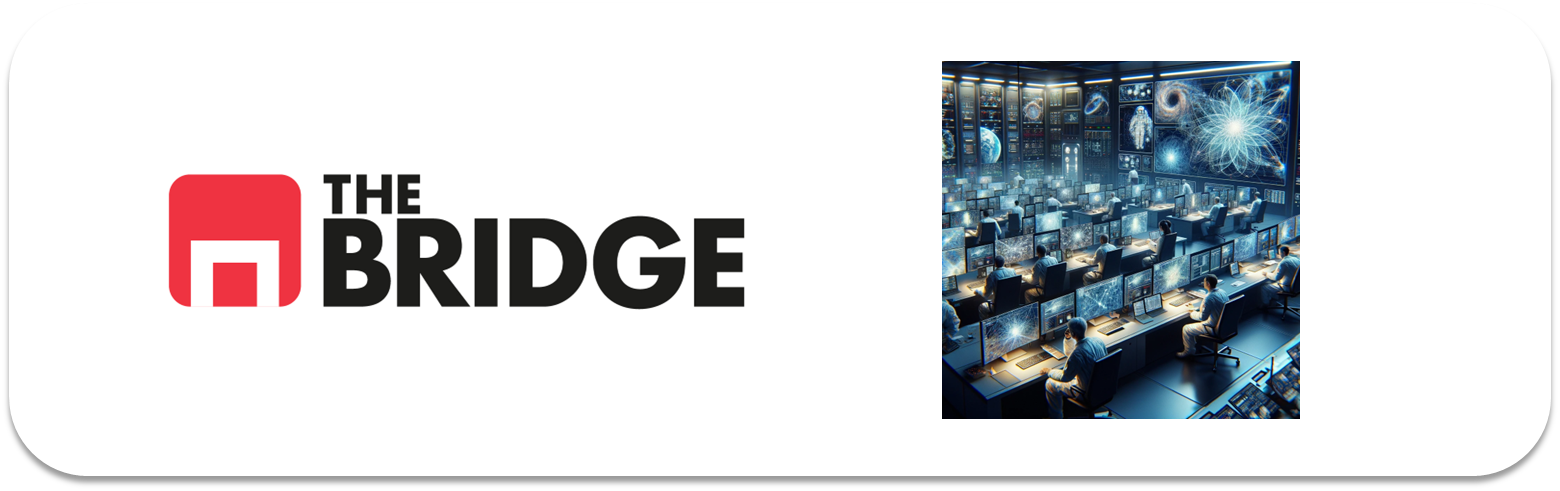

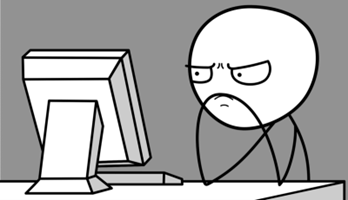

Para ejercitarte y afianzar lo aprendido sobre **Transfer Learning y Fine-tuning**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras import Model
import pandas as pd
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Apple 360

En este conjunto de ejercicios vas a montar un clasificador de manzanas mediante un dataset de imágenes. El dataset se compone de 13 tipos diferentes con aproximadamente unas 200 imágenes por cada tipo. Tendrás que montar un modelo de deep learning que utilice **transfer learning**. Se sugiere empezar con una red ResNet50 con imagenet.

El clasificador debe constar también de ***image augmentation*** para que se entrene con una mayor cantidad de casos y perspectivas de las frutas.

El dataset original proviene del [concurso de Kaggle Fruits 360](https://www.kaggle.com/moltean/fruits), pero adaptado para la clasificación de una menor cantidad de casos (sólo las manzanas).


### Ejercicio 1

Crea los juegos de X,y para train y test a partir de los datos teninendo en cuenta su distribución, para ello tendrás que explorar las estructura. Crea un juego Train,test para resolución 32x32 y un juego de test adicional para 224x224. Es decir tendras que tener un X_train, X_test para 32x32 y un X_test adicional a 224x224

In [122]:
# Procedemos a importar los datos desde la carpeta de apples, es necesario observar la estructura de la carpeta
TRAIN_PATH = './data/apples/Train'
TEST_PATH = './data/apples/Test'

In [123]:
# Cargamos cada imagen y su etiqueta
X_train = []
y_train = []

for category in os.listdir(TRAIN_PATH):
    for file in os.listdir(os.path.join(TRAIN_PATH, category)):
        img = plt.imread(os.path.join(TRAIN_PATH, category, file))
        img = cv2.resize(img, (32, 32))
        X_train.append(img)
        y_train.append(category)

In [124]:
# Transformamos a numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

In [125]:
# Verificamos que la carga de datos sea correcta
print(X_train.shape)
print(y_train.shape)

(6404, 32, 32, 3)
(6404,)


In [126]:
# Cargamos los datos de test
X_test = []
y_test = []

for category in os.listdir(TEST_PATH):
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (32, 32))
        X_test.append(img)
        y_test.append(category)

# Transformamos a numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

In [127]:
# Verificamos que la carga de datos sea correcta
print(X_test.shape)
print(y_test.shape)

(2134, 32, 32, 3)
(2134,)


*Tenemos bastantes manzanas de datos. Además son a color y en 32x32 de resolución. Vayamos con la visualización*

*Creamo el juego de test con mayor resolución para que hacer Zero Shot Learning con ResNetv50, que exige ese tamaño*

In [128]:
# Cargamos los datos de test
X_test_224 = []
y_test_224 = []

for category in os.listdir(TEST_PATH):
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (224, 224))
        X_test_224.append(img)
        y_test_224.append(category)

# Transformamos a numpy arrays
X_test_224 = np.array(X_test_224)
y_test_224 = np.array(y_test_224)

**NOTA:** A partir de aquí emplea siempre el X_train, X_test de 32x32 salvo en el ejercicio que se te diga lo contrario.

### Ejercicio 2

Haz una visualización de algunos de los datos. Crea una función que te ayude con ello.

Text(0.5, 1.0, 'Braeburn')

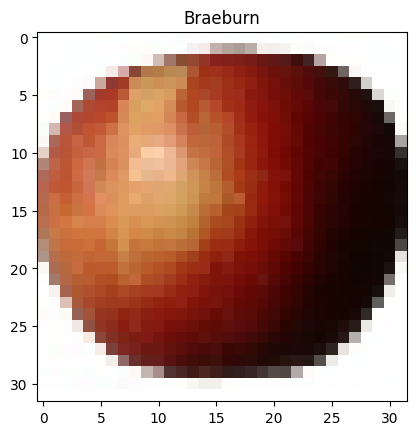

In [129]:
# Vamos a ver una imagen
plt.imshow(X_train[0])
plt.title(y_train[0])

Text(0.5, 1.0, 'Braeburn')

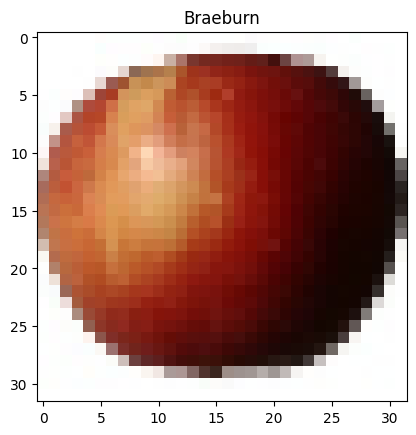

In [130]:
# Veamos una imagen de test
plt.imshow(X_test[0])
plt.title(y_test[0])

*Creamos ahora una función que espera "batches" de datos en formato numpy array*

In [131]:
def show_images_batch(apples, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(apples) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, apple in enumerate(apples):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(apple)
        plt.axis("off")
        if len(names):
            plt.title(names[index])

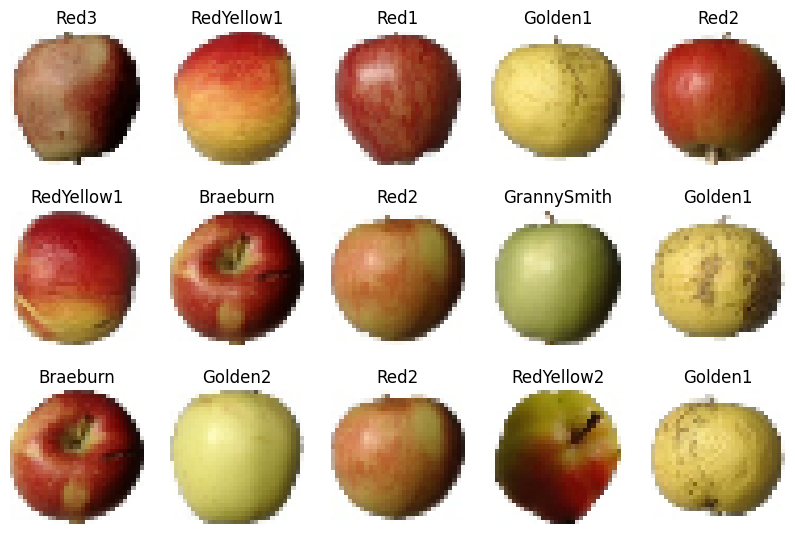

In [132]:
indices = np.random.randint(0,len(X_train),15)
show_images_batch(X_train[indices], y_train[indices])

*Veamos algunas de las de resolución 224x224*

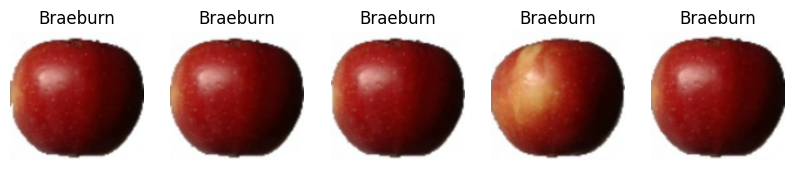

In [133]:
show_images_batch(X_test_224[23:28],y_test_224[23:28])

### Ejercicio 3

Completa el miniEDA habitual con imágenes y escoge una métrica para el modelo.

*Hacemos nuestro análisis del target y además escalamos después*

In [134]:
pd.Series(y_train).value_counts(normalize = True)

RedYellow2      0.104934
Braeburn        0.076827
Golden2         0.076827
GrannySmith     0.076827
Red1            0.076827
Red2            0.076827
RedYellow1      0.076827
RedDelicious    0.076515
Golden3         0.075109
Golden1         0.074953
PinkLady        0.071205
CrimsonSnow     0.069332
Red3            0.066989
Name: proportion, dtype: float64

*Tenemos 13 clases y una distribución uniforme más o menos para todas salvo para la RedYellow2 que es un poco más mayoritaria. En un caso real deberíamos probar a hacer un undersampling de esta categoría en caso de que el modelo no nos termine de gustar, para el resto de ejercicicos vamos a conformarnos con esta distribución y vamos a emplar la métrica de accuracy como buena*

### Ejercicio 4 

Termina de transformar los datos si crees que es conveniente y aunque el entrenamiento de modelos de keras ya tiene un shuffling interno, haz un "barajado" del X_train (del X_test no es necesario) para facilitar la convergencia inicial del modelo. Utiliza la función shuffle de sklearn y asigna la salida a un X_train distinto (es decir no machaques el inicial)

In [135]:
# Escalamos las imágenes
X_train = X_train / 255
X_test = X_test / 255

In [136]:
# Barajamos los datos, nos interesa hacerlo con train puesto que son a partir de los cuales aprende el modelo
X_train_s, y_train_s = shuffle(X_train, y_train, random_state=42)

### Ejercicio 5

Sklearn permite trabajar con etiquetas textuales pero keras no. Transforma las etiquetas a numéricas, creando dos diccionarios uno que permita traducir de etiqueta a clase numérica y otro que permita la transformación inversa.

In [16]:
# Maopeamos las categorías a números
categorias = np.unique(y_train)
n_categorias = len(categorias)

mapping = {cat: i for i, cat in enumerate(categorias)}
inverse_mapping = {valor:clave for clave,valor in mapping.items()}

In [17]:
# Observamos el mapeo
mapping

{'Braeburn': 0,
 'CrimsonSnow': 1,
 'Golden1': 2,
 'Golden2': 3,
 'Golden3': 4,
 'GrannySmith': 5,
 'PinkLady': 6,
 'Red1': 7,
 'Red2': 8,
 'Red3': 9,
 'RedDelicious': 10,
 'RedYellow1': 11,
 'RedYellow2': 12}

In [18]:
inverse_mapping

{0: 'Braeburn',
 1: 'CrimsonSnow',
 2: 'Golden1',
 3: 'Golden2',
 4: 'Golden3',
 5: 'GrannySmith',
 6: 'PinkLady',
 7: 'Red1',
 8: 'Red2',
 9: 'Red3',
 10: 'RedDelicious',
 11: 'RedYellow1',
 12: 'RedYellow2'}

In [137]:
# Mapeamos las etiquetas
y_train_num = np.array([mapping[cat] for cat in y_train_s])
y_test_num = np.array([mapping[cat] for cat in y_test])

### Ejercicio 6: Zero Shot Learning

Descar el modelo ResNet50 preparado ya para poder usarlo directamente a la Zero Shot Learning. Pruébalo contra el test (aquí no valen nuestras categorías serán las que proporcione ResNet ojo). Prueba una selección aleatoria de imágenes del test y compara las etiquetas de ResNet con la que tiene. ¿Nos sirve este clasificador así tal cual?

In [34]:
# Hay que descargar el decodificador de predicciones para poder hacer el Zero Shot
from tensorflow.keras.applications.resnet_v2 import decode_predictions

In [24]:
base_model = ResNet50V2(include_top=True, weights='imagenet', input_shape=(224, 224, 3))

In [29]:
seleccion = np.random.randint(0,len(X_test_224),20)
predictions = base_model.predict(X_test_224[seleccion])

1/1 [==============================] - 1s 1s/step


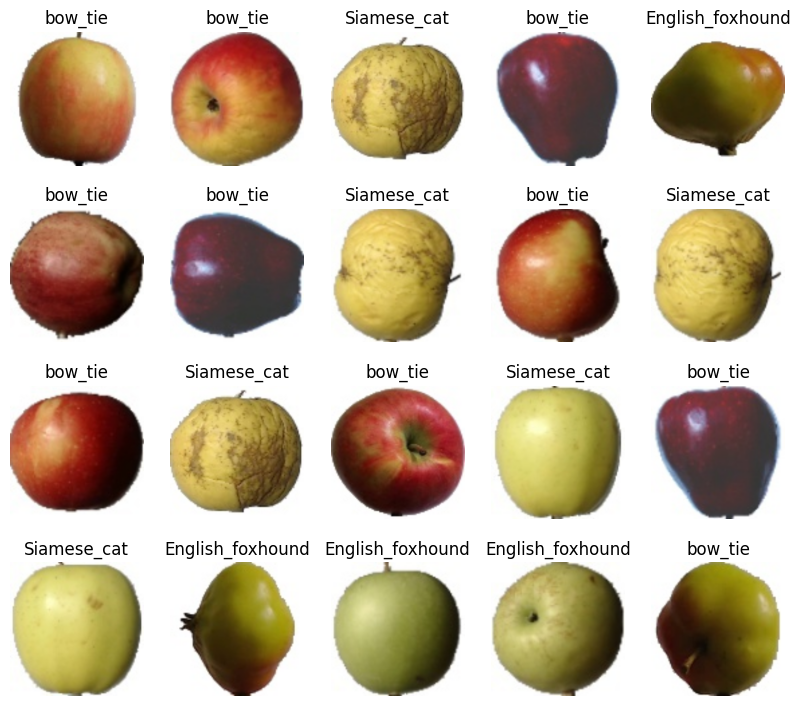

In [39]:
clase = [decodificado[0][1] for decodificado in decode_predictions(predictions)]
show_images_batch(X_test_224[seleccion], names = clase)

*Un pequeño... desastre, porque las clases no coinciden con las nuestras, otra cosa es que clasifique en clases similares las imágenes y pudieramos hacernos un mapeador. Es necesario transfer_learning o fine_tunning*

## Transfer Learning

### Ejercicio 7:

Carga la ResNet50 sin cabezas, crea un modelo con el anterior y una cabeza con dos capas densas, una oculta de 300 unidades (con activación "relu") y otra de salida con las unidades que crees necesarias y activación la que consideres. Congela las capas del modelo base (la ResNet50). Define también los hiperparámetros necesarios para compilar y compila el modelo y muestra un summary del mismo.

In [81]:
# Cargamos el modelo pre-entrenado
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = layers.Flatten()(base_model.output)
    
    # Capa densa con 300 neuronas
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)

    
    # Capa final de salida con 13 neuronas y activación softmax
    x = layers.Dense(13, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 18, 18, 64)           0         ['conv1_conv[0][0]']          
                                                                                            

### Ejercicio 8

Entrena el modelo con nuestros datos de train y muestra la evolución del entrenamiento. Emplea un callback de Earlystopping con patience a 5. Termina de escoger el batch_size y el número de épocas.

In [57]:
earlyS = EarlyStopping(patience= 5, restore_best_weights= True)

*Para escoger el batch_size (si no queremos usar el "clásico" 32):*

In [58]:
X_train_s.shape

(6404, 32, 32, 3)

In [59]:
instancias_train = len(X_train)
for i in range(1,5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {round(instancias_train/(32*i))}")

Batch_size: 32, num_steps_per_epoch: 200
Batch_size: 64, num_steps_per_epoch: 100
Batch_size: 96, num_steps_per_epoch: 67
Batch_size: 128, num_steps_per_epoch: 50


*Pues vamos a por batches de 64 que sería un número mágico 100 steps por época, esto es totalmente "intuitivo"*

In [74]:
batch_size = 64

*Primero entrena una época para ver los tiempos*

In [71]:
# Entrenamos el modelo
from time import time
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=1,)
print(time() - t_zero)

41/41 [==============================] - 8s 142ms/step - loss: 1.0745 - acc: 0.7164 - val_loss: 0.3002 - val_acc: 0.9251
8.001044273376465


*Bueno, en mi caso casi 10 segundos, y una accuracy desmedida en validación :-/, tiene pinta de que el overfitting es del bueno... lo veremos cuando evaluemos contra test*

In [85]:
# Entrenamos el modelo
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=20,
                   callbacks=[earlyS])

Epoch 1/20
81/81 [==============================] - 10s 94ms/step - loss: 1.1591 - acc: 0.6557 - val_loss: 0.2837 - val_acc: 0.9258
Epoch 2/20
81/81 [==============================] - 7s 87ms/step - loss: 0.3163 - acc: 0.9008 - val_loss: 0.1227 - val_acc: 0.9828
Epoch 3/20
81/81 [==============================] - 7s 85ms/step - loss: 0.1781 - acc: 0.9463 - val_loss: 0.0721 - val_acc: 0.9891
Epoch 4/20
81/81 [==============================] - 7s 87ms/step - loss: 0.1204 - acc: 0.9656 - val_loss: 0.0356 - val_acc: 0.9977
Epoch 5/20
81/81 [==============================] - 7s 85ms/step - loss: 0.0784 - acc: 0.9799 - val_loss: 0.0271 - val_acc: 0.9977
Epoch 6/20
81/81 [==============================] - 7s 86ms/step - loss: 0.0544 - acc: 0.9869 - val_loss: 0.0189 - val_acc: 0.9984
Epoch 7/20
81/81 [==============================] - 7s 88ms/step - loss: 0.0397 - acc: 0.9916 - val_loss: 0.0150 - val_acc: 0.9992
Epoch 8/20
81/81 [==============================] - 7s 89ms/step - loss: 0.0358 - 

*Claramente sin pintar la evolución los valores de accuracy son exageradamente altos, y hay que pensar que una ResNet permite overfittear, por lo que habría que buscar alguna manera de regularizar más, por ejemplo metiendo regularización L2 en el optimizador con el parámetros weight_decay o haciéndolo directamente en cada capa (consultar la docu de Keras). En el siguiente ejercicio veremos hasta que punto disminuye esa accuracy respecto al test*

In [76]:
evol = pd.DataFrame(history.history)

<Axes: >

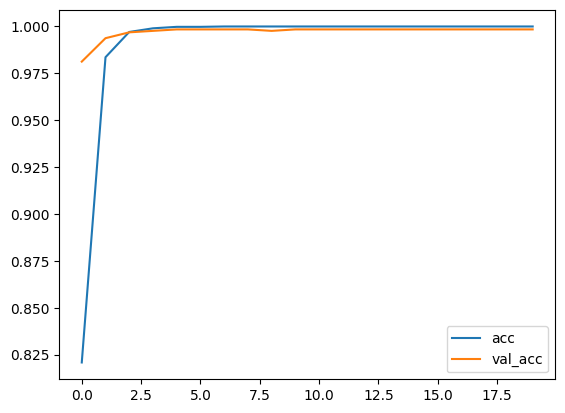

In [77]:
evol[["acc","val_acc"]].plot()

*Solo necesitamos un par de épocas para alcanzar el overfitting*

<Axes: >

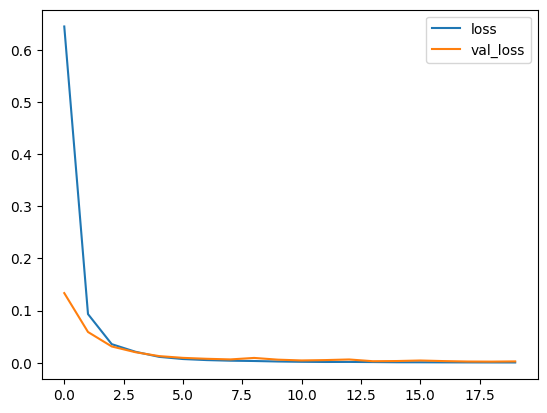

In [78]:
evol[["loss","val_loss"]].plot()

*Y aunque la pérdida sigue cayendo podríamos haber creado algún tipo de tolerancia para no añadir epocas innecesariamente. Por ejemplo:*

In [79]:
earlyS = EarlyStopping(min_delta = 0.001, restore_best_weights= True)

### Ejercicio 9

Evalua el modelo contra test y haz un pequeño análisis de las diferencias. Haz un clasification report y muestra la matriz de confusion. Haz un pequeño análisis de errores.

In [86]:
# Evaluamos el modelo
model.evaluate(X_test, y_test_num)

67/67 [==============================] - 3s 51ms/step - loss: 0.4840 - acc: 0.8500


[0.484007865190506, 0.8500468730926514]

*Como tendríamos que esperar el modelo con tanta potencia hace overfitting, además de las posibles regularizaciones, inclusión de dropout quizás podríamos reducir las unidades de la capa densa, en cualquier caso es más de un 80% de accuracy para empezar, no está mal, sin haber tocado nada más*

In [88]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

67/67 [==============================] - 3s 47ms/step
              precision    recall  f1-score   support

    Braeburn       0.75      0.83      0.79       164
 CrimsonSnow       0.83      0.89      0.86       148
     Golden1       0.69      0.99      0.82       160
     Golden2       0.96      0.93      0.95       164
     Golden3       0.64      0.50      0.56       161
 GrannySmith       0.99      0.79      0.88       164
    PinkLady       0.80      0.84      0.82       152
        Red1       0.94      0.78      0.85       164
        Red2       0.63      0.72      0.67       164
        Red3       0.94      0.73      0.82       144
RedDelicious       1.00      0.99      1.00       166
  RedYellow1       0.99      1.00      0.99       164
  RedYellow2       0.97      0.99      0.98       219

    accuracy                           0.85      2134
   macro avg       0.86      0.85      0.85      2134
weighted avg       0.86      0.85      0.85      2134



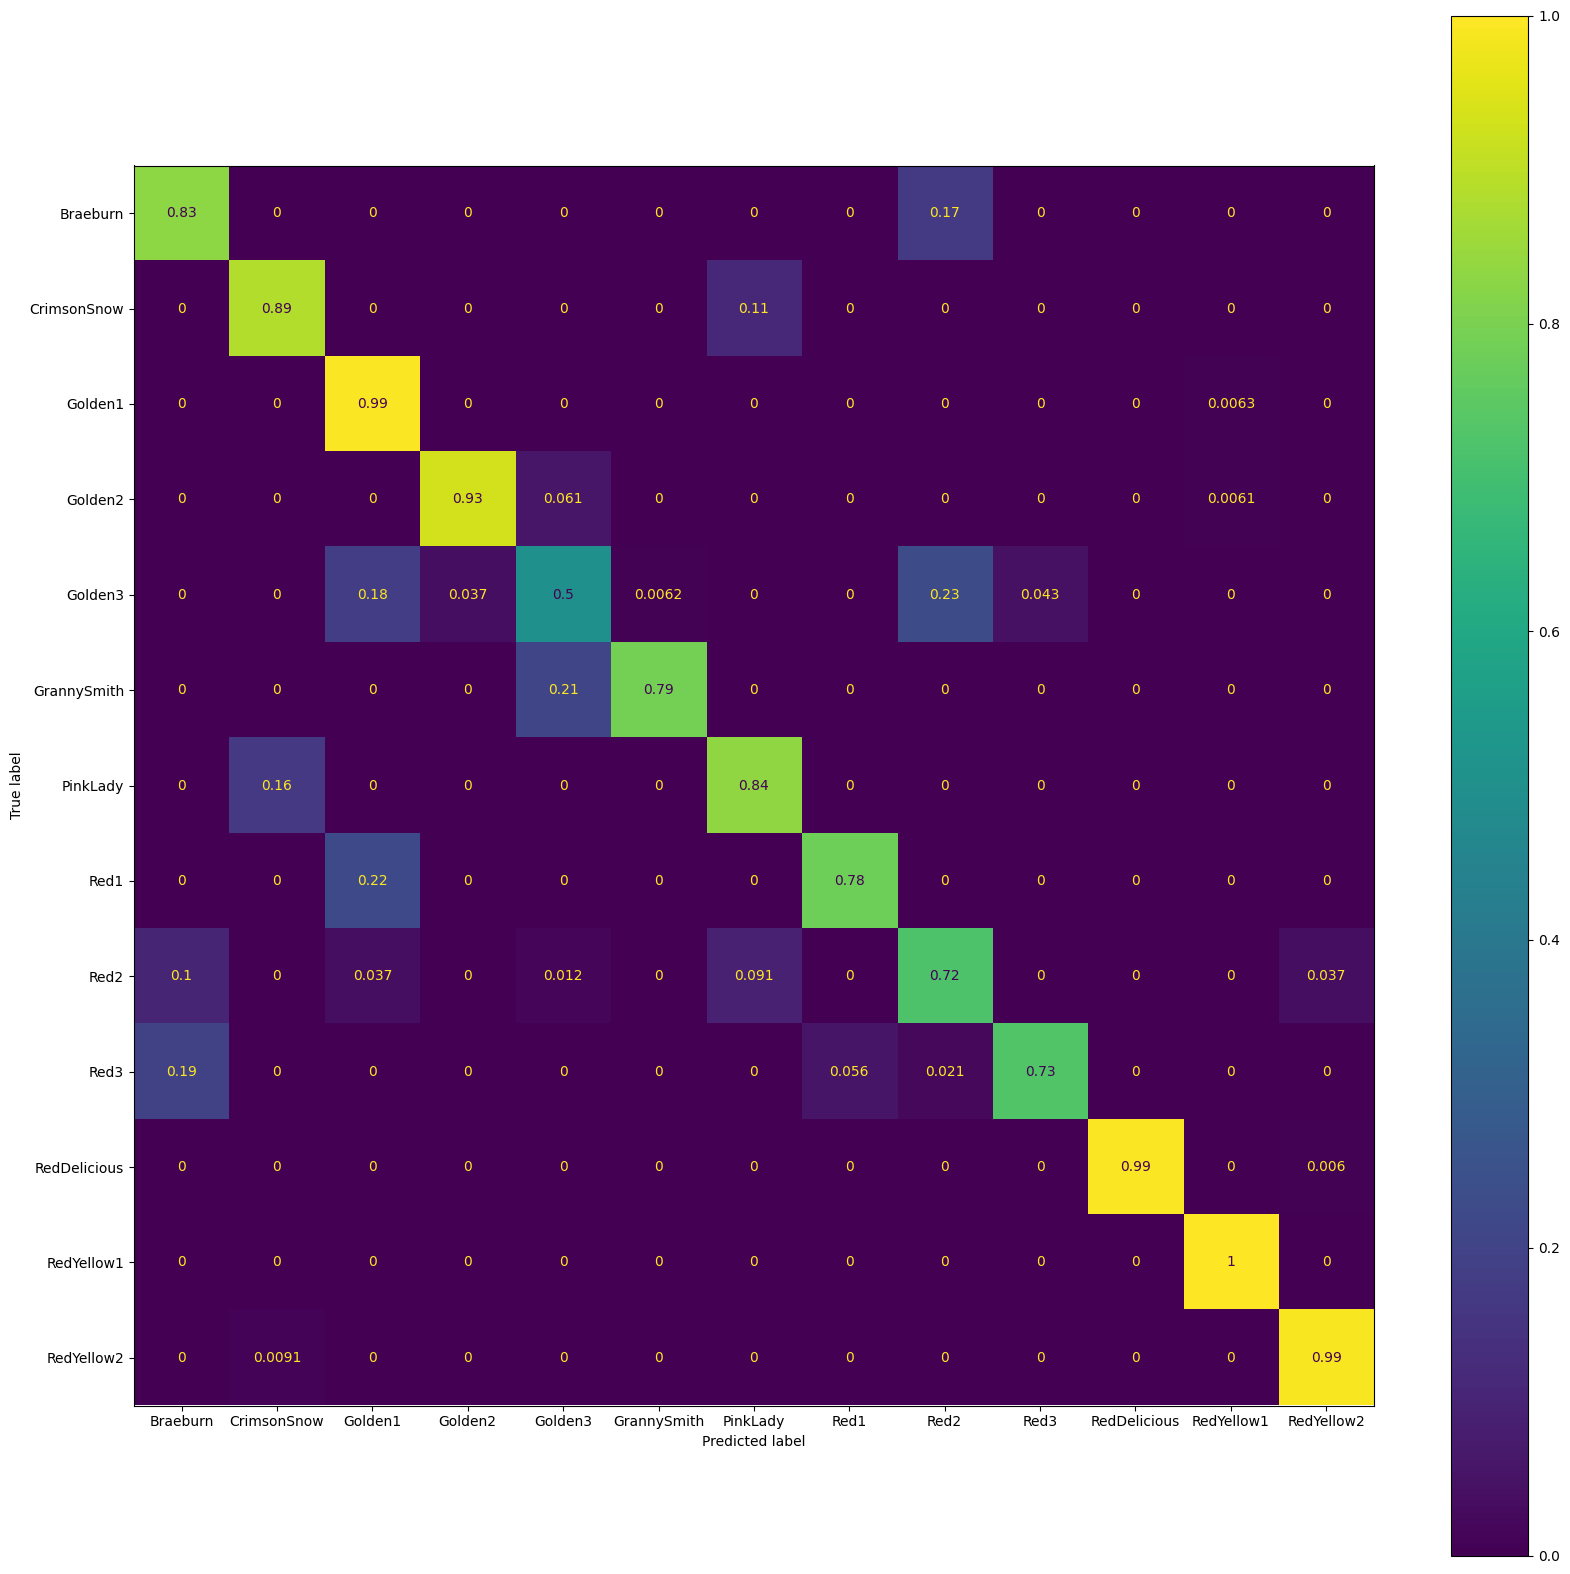

In [95]:
fig,axs = plt.subplots(1,1,figsize = (20,20))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = "true", ax = axs)

*No está nada mal, aunque hay algún tipo que deja un poco que desear, en concreto el Golden3 que tiende a confundirse con Golden1 y con Red2. Y luego hay aciertos espectaculares como las RedX (Deliciousm Yellow1, Yellow2) y la Golden tipo 1 o la golden tipo 2*

*Visualmente, veamos algunos de los errores a partir de un dataframe de resultados*

In [97]:
resultados = pd.DataFrame({"True": y_test, "Predicted": y_pred})

In [111]:
errores = resultados["True"] != resultados["Predicted"]
es_Golden3 = resultados["True"] == "Golden3"
predicted_Red2 = resultados["Predicted"] == "Red2"
es_Red2 = resultados["True"] == "Red2"

*Mostramos las Golden3 que ha confundido el modelo con Red2, hay que tener en cuenta que las Golden3 son las que peor se le dan*

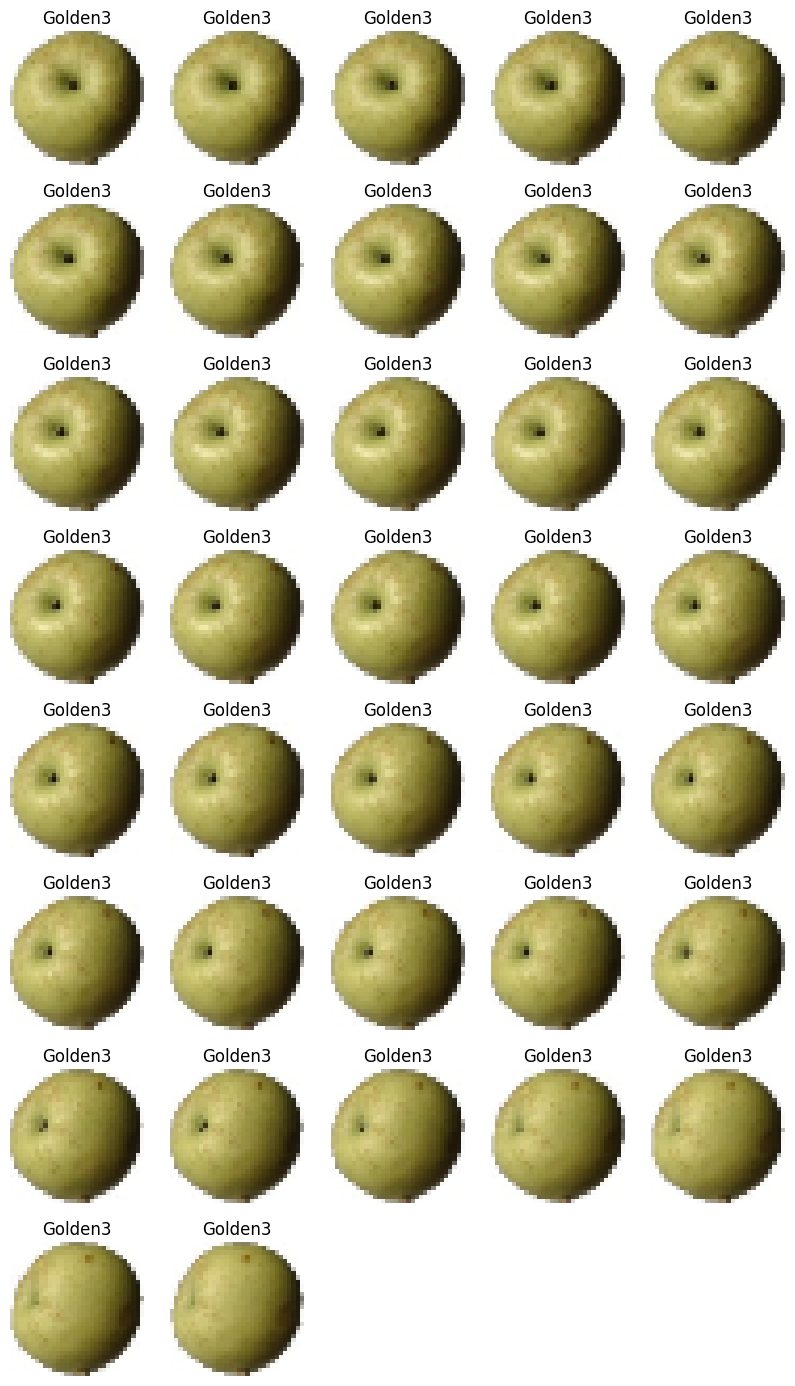

In [110]:
show_images_batch(X_test[resultados[es_Golden3 & predicted_Red2].index], y_test[resultados[es_Golden3 & predicted_Red2].index])

*Para comparar unas Red2 que detecta correctamente*

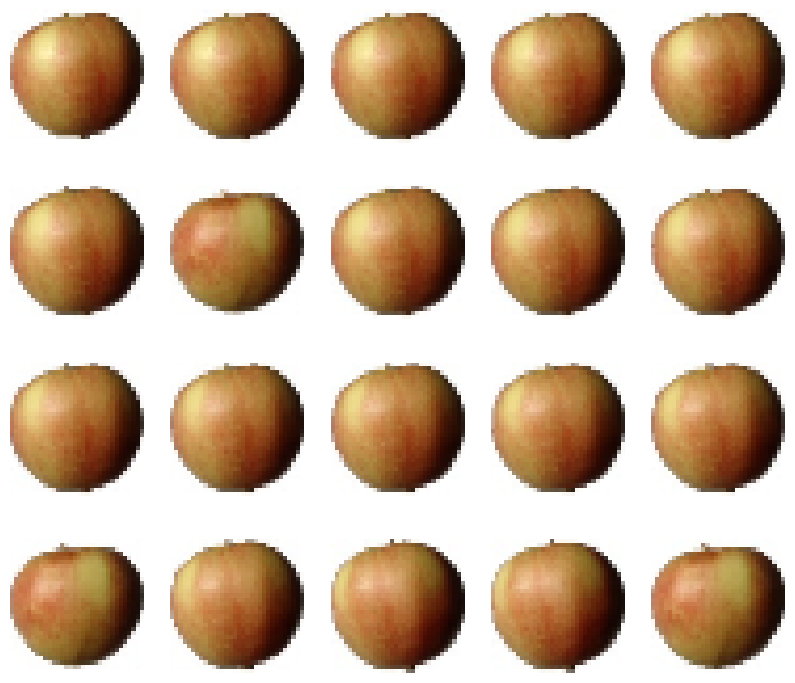

In [114]:
show_images_batch(X_test[resultados[es_Red2 & predicted_Red2].index[20:40]])

*Y algunas Golden3 bien etiquetadas*

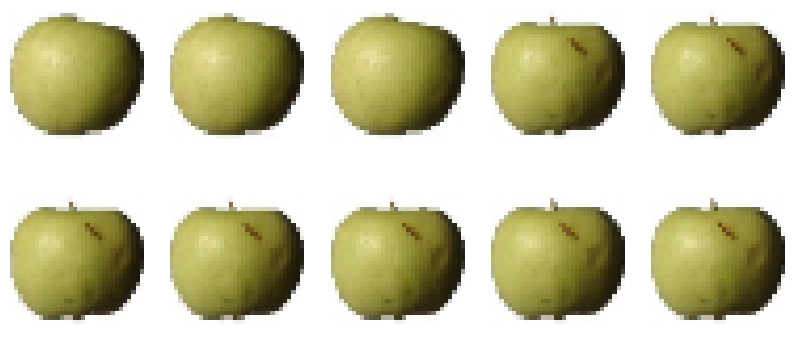

In [117]:
show_images_batch(X_test[resultados[es_Golden3 & (errores == False)].index[0:10]])

*Hmmm, curiosos errores*

## Fine Tuning

### Ejercicio 10

Vuelve a descargar el modelo ResNet50 pero sin pesos entrenados, ni cabeza, crea el mismo modelo personalizado que en el ejercicio 7, compila y muestra el summary.

In [142]:
# Cargamos el modelo pre-entrenado
base_model = ResNet50V2(include_top=False, weights=None, input_shape=(32, 32, 3))

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = layers.Flatten()(base_model.output)
    
    # Capa densa con 300 neuronas
    x = layers.Dense(300, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)

    
    # Capa final de salida con 13 neuronas y activación softmax
    x = layers.Dense(13, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 18, 18, 64)           0         ['conv1_conv[0][0]']          
                                                                                           

### Ejercicio 11
Entrena con batch_size a 64 y 60 épocas, con un EarlyStopping de patience a 10 (ahora el entrenamiento es sensiblemente más largo, así que tómate un descanso). Muestra la evolución y da una posible justificación a emplear tantas épocas de partida.

In [149]:
earlySFT = EarlyStopping(restore_best_weights= True, patience= 10)

In [150]:
# Entrenamos el modelo
from time import time
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_num,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=60,
                   callbacks= earlySFT)
print(time() - t_zero)

Epoch 1/60
81/81 [==============================] - 40s 375ms/step - loss: 0.2344 - acc: 0.9440 - val_loss: 20.8626 - val_acc: 0.4418
Epoch 2/60
81/81 [==============================] - 31s 385ms/step - loss: 0.2126 - acc: 0.9584 - val_loss: 24.9930 - val_acc: 0.3966
Epoch 3/60
81/81 [==============================] - 32s 395ms/step - loss: 0.1917 - acc: 0.9551 - val_loss: 1.3814 - val_acc: 0.7799
Epoch 4/60
81/81 [==============================] - 32s 391ms/step - loss: 0.0717 - acc: 0.9820 - val_loss: 1.3163 - val_acc: 0.8782
Epoch 5/60
81/81 [==============================] - 31s 388ms/step - loss: 0.1709 - acc: 0.9633 - val_loss: 5.9029 - val_acc: 0.4294
Epoch 6/60
81/81 [==============================] - 31s 386ms/step - loss: 0.0742 - acc: 0.9807 - val_loss: 3.9355 - val_acc: 0.6550
Epoch 7/60
81/81 [==============================] - 32s 392ms/step - loss: 0.0906 - acc: 0.9781 - val_loss: 0.1017 - val_acc: 0.9617
Epoch 8/60
81/81 [==============================] - 31s 379ms/step 

<Axes: >

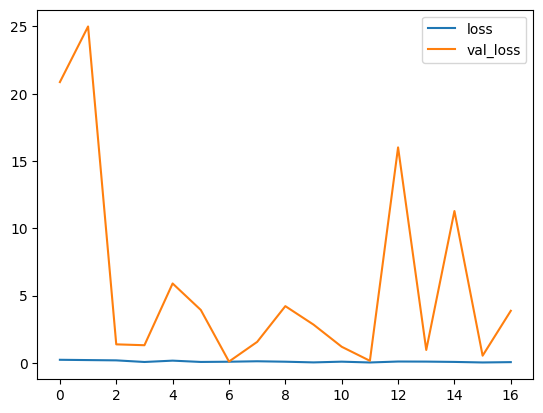

In [151]:
df_evol = pd.DataFrame(history.history)
df_evol[["loss","val_loss"]].plot()

*EL problema con redes tan grandes y la cantidad de datos que tenemos es que la oscilación de los resultados es tremenda y la sensibilidad a la inicialización también. El modelo tarda en encontrar valores de pérdida bajos para validación y si repites el entrenamiento puede que tarde mucho más o menos en encontrar valores interesantes. Quizá vendría bien aumentar el batch size para que la selección aleatoria le afecte menos. Lo que sí ocurre es que si escogemos valores bajos de número de épocas es posible que el modelo nunca llegue a "calentar" como para salir de los mínimos locales que ha ido encontrando y no obtenga buenas prestaciones. Como puedes ver un finetuning de modelos grandes necesita de ... datos y paciencia*

### Ejercicio 12

Muestra la evaluación contra el test, el informe de clasificación  y la matriz de confusión. Compara los resultados con los del ejercicio 9.

In [152]:
model.evaluate(X_test, y_test_num)

67/67 [==============================] - 3s 47ms/step - loss: 0.1550 - acc: 0.9433


[0.15496261417865753, 0.9432989954948425]

*Para este test set la paciencia y el supermodelo han sido un buen ejemplo, por lo menos para mi modelado, puede que el tuyo no haya salido tan bueno*

In [153]:
y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

67/67 [==============================] - 4s 47ms/step
              precision    recall  f1-score   support

    Braeburn       1.00      0.99      1.00       164
 CrimsonSnow       1.00      1.00      1.00       148
     Golden1       0.76      0.66      0.71       160
     Golden2       0.85      1.00      0.92       164
     Golden3       0.74      1.00      0.85       161
 GrannySmith       1.00      0.80      0.89       164
    PinkLady       1.00      1.00      1.00       152
        Red1       1.00      1.00      1.00       164
        Red2       0.99      1.00      1.00       164
        Red3       1.00      1.00      1.00       144
RedDelicious       1.00      1.00      1.00       166
  RedYellow1       1.00      0.80      0.89       164
  RedYellow2       1.00      1.00      1.00       219

    accuracy                           0.94      2134
   macro avg       0.95      0.94      0.94      2134
weighted avg       0.95      0.94      0.94      2134



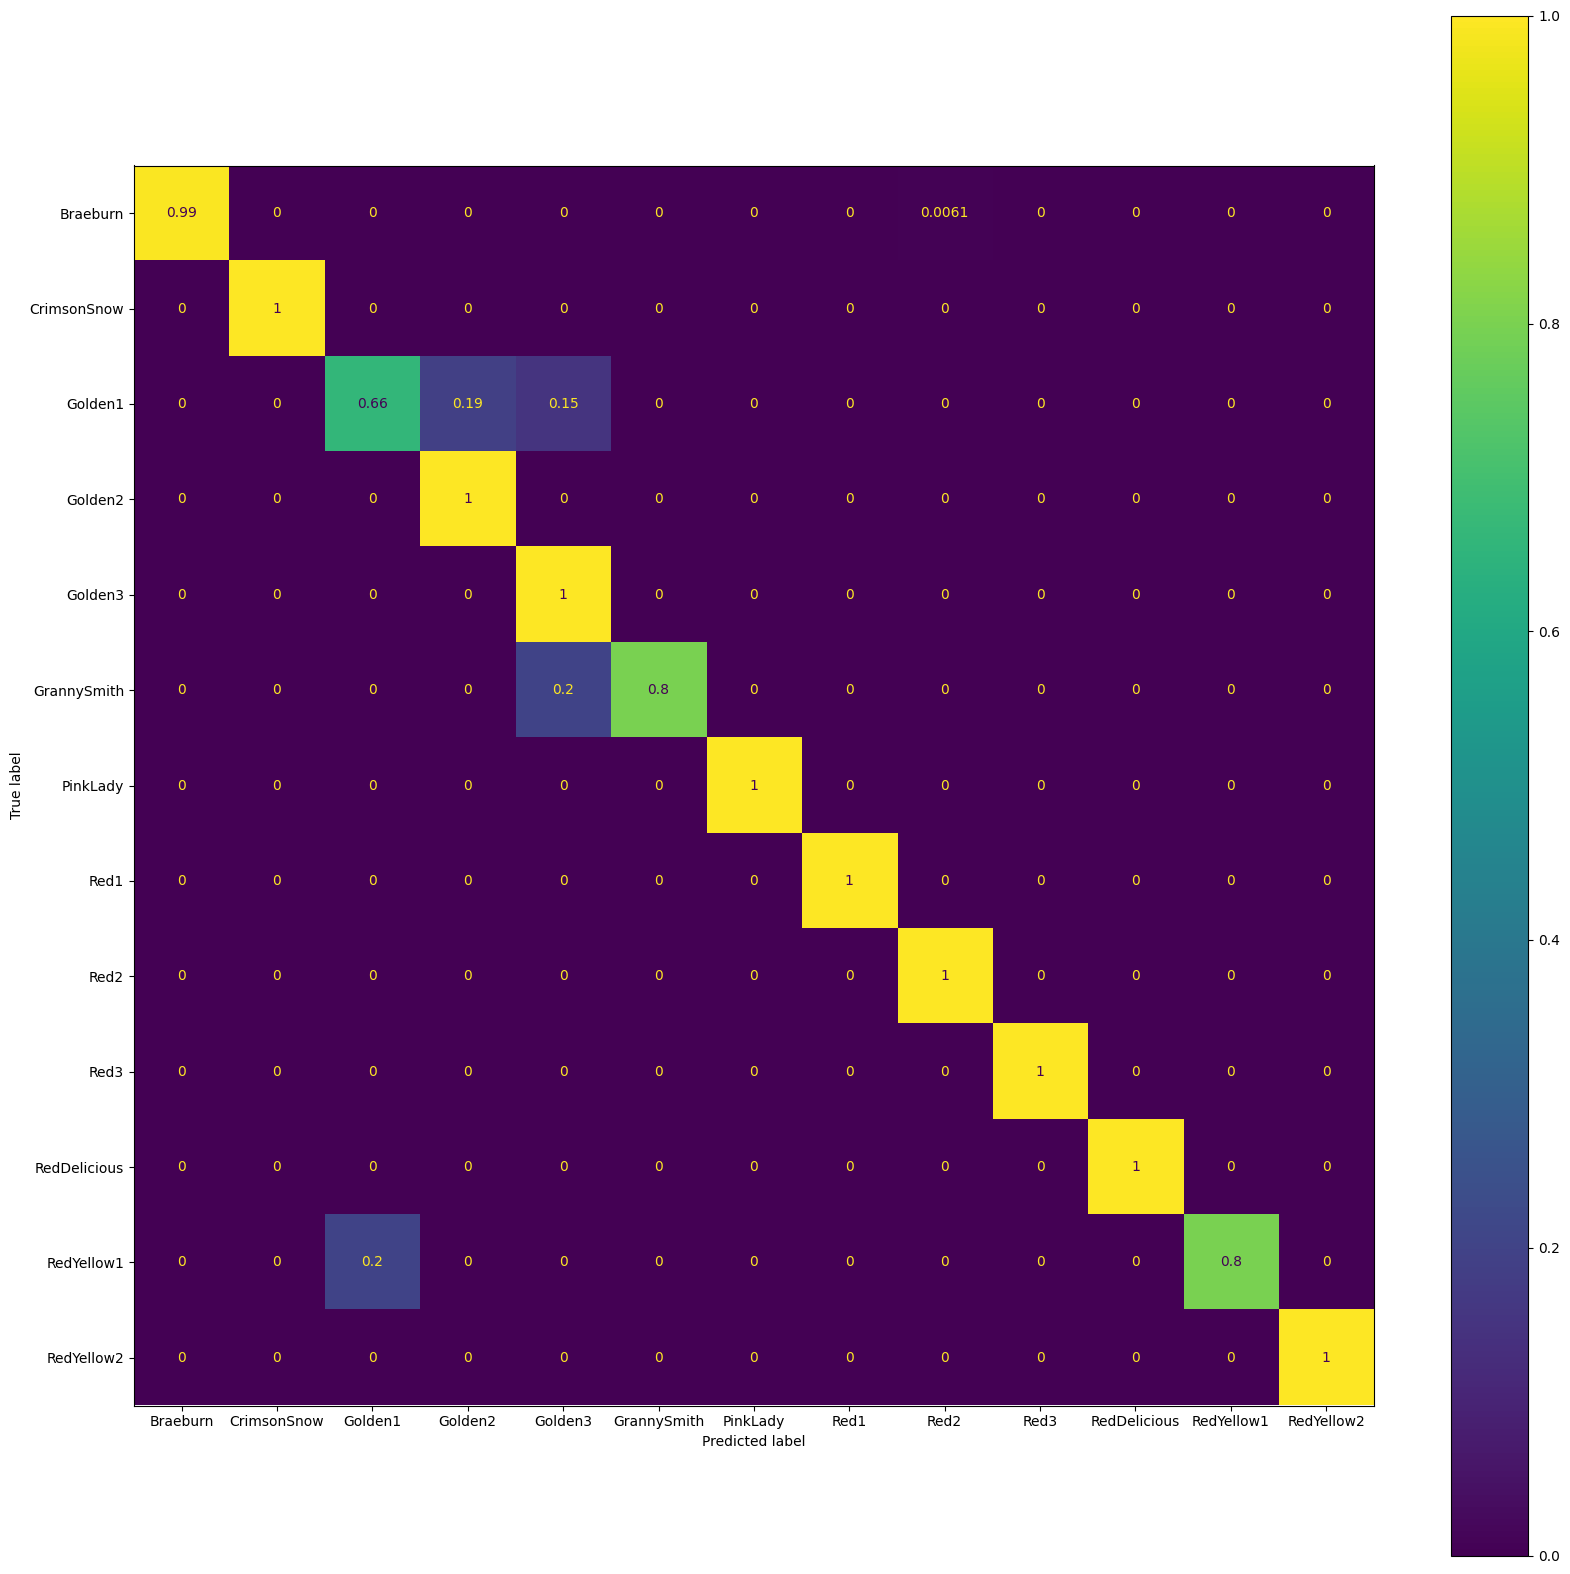

In [154]:
fig,axs = plt.subplots(1,1,figsize = (20,20))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = "true", ax = axs)